In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import datasets
from tqdm import tqdm

In [2]:
STOPWORDS = set(stopwords.words('english'))
MAX_WORDS = 20000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 50

In [3]:
def clean_dataset(df):
    df.drop('id', axis = 1, inplace = True)
    df.columns = ['TEXTS_COLUMN', 'LABELS_COLUMN']
    
    for i in tqdm(range(len(df))):
        for j in df.loc[i, 'LABELS_COLUMN']:
            df.loc[i, j] = 1
        if len(df.loc[i, 'LABELS_COLUMN']) == 1:
            df.loc[i, 'LABELS_COLUMN'] = df.loc[i, 'LABELS_COLUMN'][0]
            
    df.replace(np.nan, 0, inplace = True)
    
    return df

def clean_text(text):
    # Text to lower case
    text = text.lower()
    #Remove stop words, extra characters, digits and other tags:
    text = re.sub(r'[/(){}\[\]\|@,;]', '', text)
    text = re.sub(r'[^0-9a-z #+_]', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

def freqs(texts):
    freqs_dict = {}
    for text in texts:
        text = clean_text(text).split()
        for word in text:
            if word in freqs_dict.keys():
                freqs_dict[word] += 1
            else:
                freqs_dict[word] = 1
    
    return freqs_dict

In [4]:
dataset = datasets.load_dataset('go_emotions')
train, test, val = pd.DataFrame(dataset['train']), pd.DataFrame(dataset['test']), pd.DataFrame(dataset['validation'])
clean_train, clean_test, clean_val = clean_dataset(train), clean_dataset(test), clean_dataset(val)

clean_train['TEXTS_COLUMN'] = clean_train.TEXTS_COLUMN.apply(clean_text)
clean_test['TEXTS_COLUMN'] = clean_test.TEXTS_COLUMN.apply(clean_text)
clean_val['TEXTS_COLUMN'] = clean_val.TEXTS_COLUMN.apply(clean_text)

print('Maximum sequence length:',max([len(text.split()) for text in clean_train['TEXTS_COLUMN']]))
print('Mean sequence length:',np.mean([len(text.split()) for text in clean_train['TEXTS_COLUMN']]))

No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (C:\Users\maste\.cache\huggingface\datasets\go_emotions\simplified\0.0.0\2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████| 5426/5426 [00:00<00:00, 6234.65it/s]


Maximum sequence length: 29
Mean sequence length: 6.880879981571066


In [5]:
frequency_dict = freqs(clean_train['TEXTS_COLUMN'])
print(len(frequency_dict))

28223


In [6]:
tokenizer = Tokenizer(num_words = 20000, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(clean_train['TEXTS_COLUMN'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 28092 unique tokens.


In [7]:
X_train = tokenizer.texts_to_sequences(clean_train['TEXTS_COLUMN'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

X_val = tokenizer.texts_to_sequences(clean_val['TEXTS_COLUMN'].values)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_val.shape)
X = np.concatenate((X_train, X_val), axis = 0)

Shape of data tensor: (43410, 50)
Shape of data tensor: (5426, 50)


In [8]:
Y_train = pd.get_dummies(clean_train[[i for i in range(28)]]).values
Y_val = pd.get_dummies(clean_val[[i for i in range(28)]]).values
Y = np.concatenate((Y_train, Y_val), axis = 0)

In [9]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(28, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 28)                2828      
Total params: 2,083,228
Trainable params: 2,083,228
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
611/611 [==============================] - 84s 135ms/step - loss: 3.1461 - accuracy: 0.3312 - val_loss: 2.8912 - val_accuracy: 0.3960
Epoch 2/10
611/611 [==============================] - 85s 138ms/step - loss: 2.7321 - accuracy: 0.4334 - val_loss: 2.7775 - val_accuracy: 0.4372
Epoch 3/10
611/611 [==============================] - 87s 142ms/step - loss: 2.6093 - accuracy: 0.4521 - val_loss: 2.7919 - val_accuracy: 0.4358
Epoch 4/10
611/611 [==============================] - 86s 141ms/step - loss: 2.5202 - accuracy: 0.4614 - val_loss: 2.8380 - val_accuracy: 0.4246
Epoch 5/10
611/611 [==============================] - 72s 118ms/step - loss: 2.4426 - accuracy: 0.4735 - val_loss: 2.8588 - val_accuracy: 0.4255


In [11]:
accuracy = model.evaluate(X_val, Y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy[0],accuracy[1]))

170/170 [==============================] - 2s 13ms/step - loss: 2.7589 - accuracy: 0.4390
Test set
  Loss: 2.759
  Accuracy: 0.439


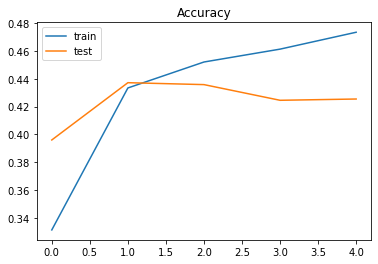

In [12]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [13]:
import praw

In [14]:
reddit = praw.Reddit(
        client_id = ,
        client_secret = ,
        password = ,
        user_agent = ,
        username = )
reddit.user.me()

Redditor(name='Otherwise-Tension237')

In [15]:
posts = []
for i in praw.models.Front(reddit).best():
    posts.append([i.id, i.title])
posts = pd.DataFrame(posts, columns = ['Post_ID', 'Post_Title'])

In [16]:
labels = ['admiration',
'amusement',
'anger',
'annoyance',
'approval',
'caring',
'confusion',
'curiosity',
'desire',
'disappointment',
'disapproval',
'disgust',
'embarrassment',
'excitement',
'fear',
'gratitude',
'grief',
'joy',
'love',
'nervousness',
'optimism',
'pride',
'realization',
'relief',
'remorse',
'sadness',
'surprise',
'neutral']
ids2labels = {i : j for i, j in enumerate(labels)}
labels2ids = {j : i for i, j in enumerate(labels)}

In [17]:
for text in posts.Post_Title:
    input_prompt = [clean_text(text)]
    seq = tokenizer.texts_to_sequences(input_prompt)
    padded = pad_sequences(seq, maxlen = MAX_SEQUENCE_LENGTH)
    prediction = model.predict(padded)
    print(f'Text:{text} \n Label1 {ids2labels[np.argmax(prediction[0])]}\n', 
          f'Label2 {ids2labels[prediction[0].argsort()[-2]]}')

Text:can I get a 💩 in chat for Muffy 
 Label1 neutral
 Label2 approval
Text:A beautiful roll cloud over Lake Michigan immortalized by Ken Temple 
 Label1 admiration
 Label2 approval
Text:sinkhole under a pool 
 Label1 neutral
 Label2 annoyance
Text:Hotel does OP's laundry and takes her to the cleaners 
 Label1 neutral
 Label2 annoyance
Text:How is that even possible! 
 Label1 neutral
 Label2 annoyance
Text:OOP is hard of hearing, and her boss mocks her voice volume level behind her back 
 Label1 neutral
 Label2 approval
Text::( 
 Label1 neutral
 Label2 approval
Text:Cop decks crazy woman for trying to bite him! 
 Label1 neutral
 Label2 annoyance
Text:Saenchai the 5’4 Muay Thai legend takes on a opponent a couple weight classes above him 
 Label1 admiration
 Label2 approval
Text:Anon lives in America.... 
 Label1 neutral
 Label2 annoyance
Text:The length what a toxic relationship will do. 
 Label1 neutral
 Label2 admiration
Text:Kitten asserts dominance 
 Label1 neutral
 Label2 annoyanc